### Imports

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error

In [84]:
raw_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
raw_train.head()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,color,Harvest Time,Average Daily Temperature During Growth (celcius),Average Temperature During Storage (celcius),Scoville Heat Units (SHU)
0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,red,Midday,8.68,5-6,0.00
1,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,green,Midday,22.44,NaN,0.00
2,6.17,3.51,66.72,7.96,298.81,4.69,125.91,6.75,72.98,2.77,red,Midday,24.99,NaN,455995.06
3,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,yellow,Midday,13.05,NaN,0.00
4,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,red,Midday,27.08,NaN,0.00


In [85]:
raw_train.describe()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,Average Daily Temperature During Growth (celcius),Scoville Heat Units (SHU)
count,999.000000,999.000000,999.000000,998.000000,999.000000,999.000000,1000.000000,999.000000,1000.000000,999.000000,1000.000000,1000.000000
mean,15.574675,6.641572,169.346406,4.619499,128.731301,4.215385,142.035180,3.283534,90.878380,3.679179,19.641960,70941.260020
std,6.267303,2.139023,123.779026,2.829503,87.270366,3.163125,72.246142,1.938264,18.724314,1.034726,6.436255,108149.917069
min,0.300000,0.100000,0.560000,0.000000,0.040000,0.010000,0.950000,0.010000,31.400000,0.850000,0.840000,0.000000
25%,11.290000,5.140000,79.020000,2.400000,55.390000,1.710000,92.290000,1.865000,78.585000,2.980000,15.397500,0.000000
50%,15.520000,6.600000,147.230000,4.280000,119.490000,3.590000,141.730000,3.140000,89.690000,3.660000,19.495000,0.000000
75%,19.900000,8.045000,227.625000,6.560000,186.845000,6.115000,192.720000,4.555000,103.200000,4.375000,23.530000,121349.617500
max,35.570000,13.620000,869.970000,14.630000,487.260000,19.020000,450.290000,9.360000,158.300000,8.250000,40.700000,527639.860000


In [86]:
print(raw_train.isnull().sum()) # view missing data


Length (cm)                                            1
Width (cm)                                             1
Weight (g)                                             1
Pericarp Thickness (mm)                                2
Seed Count                                             1
Capsaicin Content                                      1
Vitamin C Content (mg)                                 0
Sugar Content                                          1
Moisture Content                                       0
Firmness                                               1
color                                                  1
Harvest Time                                           0
Average Daily Temperature During Growth (celcius)      0
Average Temperature During Storage (celcius)         648
Scoville Heat Units (SHU)                              0
dtype: int64


In [87]:
# violin plot
#fig_violin, ax_violin = plt.subplots(nrows=3, ncols=5, figsize=(16, 9))
#plt.tight_layout(pad=3.0)

#i = 0
#for row in range(3):
    #for col in range(5):
        #sns.violinplot(ax=ax_violin[row, col], data=raw_train, x='Scoville Heat Units (SHU)', y=raw_train.columns[i], 
                       #hue='Scoville Heat Units (SHU)', split=True) # the split makes it easier to see the differenvce for edible 1 or 0
        #i += 1
        
#plt.show()

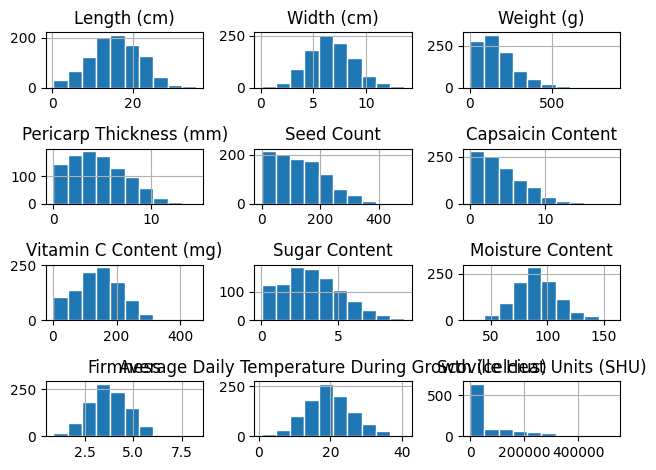

In [88]:
# Histogram 
raw_train.hist(edgecolor="white") # edgecolor makes it look nicer 
plt.tight_layout()
plt.show()

In [89]:
# drop average temperature column
train = raw_train.drop(['Average Temperature During Storage (celcius)'], axis=1)

In [90]:
# drop rows with missing data
train = train.dropna() # remove NaN values 
print(train.isnull().sum())# view if there is still missing data after removing NaN values

Length (cm)                                          0
Width (cm)                                           0
Weight (g)                                           0
Pericarp Thickness (mm)                              0
Seed Count                                           0
Capsaicin Content                                    0
Vitamin C Content (mg)                               0
Sugar Content                                        0
Moisture Content                                     0
Firmness                                             0
color                                                0
Harvest Time                                         0
Average Daily Temperature During Growth (celcius)    0
Scoville Heat Units (SHU)                            0
dtype: int64


In [91]:
train['Scoville Heat Units (SHU)'].unique()

array([0.0000000e+00, 4.5599506e+05, 7.0571100e+04, 3.1362490e+04,
       1.5599527e+05, 8.1373220e+04, 2.9175919e+05, 1.6642250e+05,
       1.7543566e+05, 6.1855570e+04, 1.8705260e+05, 2.0530600e+04,
       1.1838700e+05, 7.4246960e+04, 1.0083255e+05, 1.4739988e+05,
       1.1685380e+04, 6.9212680e+04, 1.8104676e+05, 6.8664660e+04,
       6.5944790e+04, 1.0734400e+04, 1.1375423e+05, 3.0349773e+05,
       8.3094640e+04, 1.6730470e+04, 4.5653968e+05, 9.4942390e+04,
       2.4669291e+05, 1.0668357e+05, 4.1833220e+04, 6.8900050e+04,
       8.2283800e+03, 3.2703547e+05, 8.8745420e+04, 1.6640136e+05,
       8.6767290e+04, 9.0267910e+04, 1.7641421e+05, 2.8841994e+05,
       3.8481910e+05, 3.0720863e+05, 2.6501413e+05, 9.6558260e+04,
       3.7205770e+04, 1.8238822e+05, 1.1761951e+05, 1.4128017e+05,
       2.0935552e+05, 1.8275238e+05, 3.4540496e+05, 7.8735460e+04,
       1.9442106e+05, 2.1922907e+05, 3.7579068e+05, 3.1298836e+05,
       2.9110560e+04, 3.4330051e+05, 1.3239557e+05, 1.7702565e

Text(0.5, 1.0, 'Binned SHU distribution')

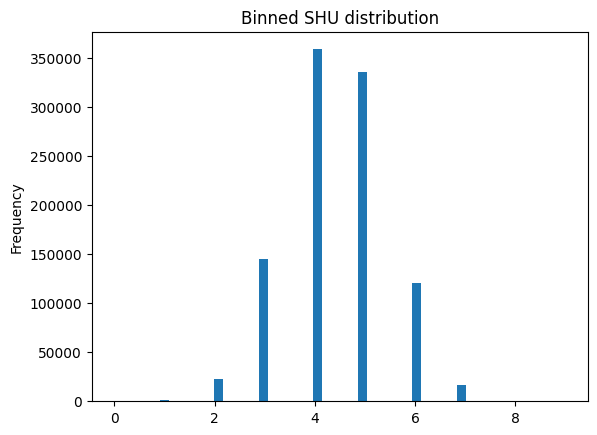

In [92]:
# binning the Scoville Heat Units (SHU) column¨
import pandas as pd
import numpy as np

# Set number of bins
num_bins = 10

# Create DataFrame with random data
df = pd.DataFrame(np.random.normal(0, 1, 1000000), columns=['Scoville Heat Units (SHU)'])

# Bin the 'Scoville Heat Units (SHU)' column
df['binned_SHU'] = pd.cut(df['Scoville Heat Units (SHU)'], num_bins, labels=False)

# Plot the target variable distribution
df['binned_SHU'].plot.hist(bins=50).set_title('Binned SHU distribution')


Text(0.5, 1.0, 'Binned SHU distribution')

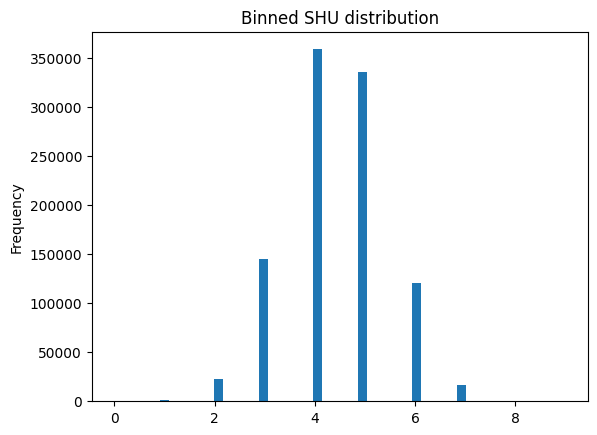

In [93]:
# Determine the minimum and maximum values of the 'Scoville Heat Units (SHU)' column
min_shu = df['Scoville Heat Units (SHU)'].min()
max_shu = df['Scoville Heat Units (SHU)'].max()

# Calculate the width of each bin
bin_width = (max_shu - min_shu) / num_bins

# Define the bin edges
bin_edges = [min_shu + i * bin_width for i in range(num_bins)]
bin_edges.append(max_shu)  # Append the maximum value to include all data points

# Bin the 'Scoville Heat Units (SHU)' column using the defined bin edges
df['binned_SHU'] = pd.cut(df['Scoville Heat Units (SHU)'], bins=bin_edges, labels=False)

# Plot the target variable distribution
df['binned_SHU'].plot.hist(bins=50).set_title('Binned SHU distribution')


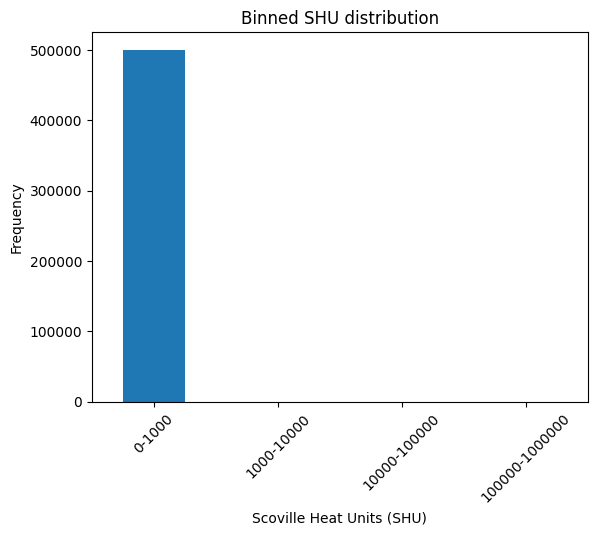

In [97]:
# Define the bin edges based on the provided categories
bin_edges = [0, 1000, 10000, 100000, 1000000]

# Bin the 'Scoville Heat Units (SHU)' column using the defined bin edges and labels
df['binned_SHU'] = pd.cut(df['Scoville Heat Units (SHU)'], bins=bin_edges, labels=['0-1000', '1000-10000', '10000-100000', '100000-1000000'])

# Plot the target variable distribution
df['binned_SHU'].value_counts().sort_index().plot(kind='bar', rot=45).set_title('Binned SHU distribution')



In [ ]:
# Using Z-scores to filter out the outliers. Z-score < |3|
from scipy import stats

# Assuming 'train' is your DataFrame and you want to filter outliers based on z-scores
numerical_cols = train.select_dtypes(include=np.number).columns

print(f'Shape of dataset before removing outliers: {train.shape}')
z_scores = stats.zscore(train[numerical_cols])
abs_z_scores = np.abs(z_scores)
not_outliers = (abs_z_scores < 3).all(axis=1)
train = train[not_outliers]
print(f'Shape of dataset after removing outliers: {train.shape}')
train.head(10)



Shape of dataset before removing outliers: (990, 14)
Shape of dataset after removing outliers: (930, 14)


,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,color,Harvest Time,Average Daily Temperature During Growth (celcius),Scoville Heat Units (SHU)
0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,red,Midday,8.68,0.00
1,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,green,Midday,22.44,0.00
3,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,yellow,Midday,13.05,0.00
4,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,red,Midday,27.08,0.00
5,13.80,8.64,189.24,4.32,72.27,2.38,140.15,4.60,117.75,3.21,yellow,Morning,24.95,0.00
6,9.15,8.40,74.69,1.70,8.45,6.22,68.89,4.02,101.63,5.54,yellow,Midday,31.34,70571.10
7,12.40,10.68,159.72,10.28,239.54,11.08,28.62,4.32,94.90,5.56,green,Midday,18.53,0.00
8,18.90,7.66,57.72,4.63,87.10,6.74,34.05,0.65,82.13,4.32,yellow,Midday,16.14,31362.49
10,22.27,7.51,391.84,0.97,347.17,2.42,295.92,4.75,110.97,3.28,red,Midday,22.33,0.00
11,11.04,6.03,111.64,3.78,99.29,1.77,227.79,5.63,122.34,3.62,red,Midday,18.97,0.00


In [ ]:
harvest = train['Harvest Time']
harvest.unique()




array(['Midday', 'Morning', 'Evening'], dtype=object)

In [ ]:
# Separate features and target variable
data = train.copy()
X = data.drop(columns=['Scoville Heat Units (SHU)'])
y = data['Scoville Heat Units (SHU)']

# Define preprocessing steps
numeric_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
# data preparation
X = train.drop(columns=['Scoville Heat Units (SHU)'])
y = train['Scoville Heat Units (SHU)']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


### A - Regression 

In [ ]:
# Pipeline for Regression Analysis
pipeline_reg = Pipeline


### Linear Regression

In [ ]:
pcr = Pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pcr.predict(X_test)

# source: Lecture_19_20_Regression/PCR_regression.ipynb

TypeError: Pipeline.__init__() takes 2 positional arguments but 4 were given

In [ ]:
pipeline_A = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

# Pipeline B: Multi-class Classification Analysis with Random Forest Regressor
pipeline_B = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', RandomForestRegressor())])

# Pipeline C: Two-step Analysis with Random Forest Classifier and Linear Regression
pipeline_C = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier()),
                             ('regressor', LinearRegression())])

In [ ]:
# Hyperparameters for Pipeline B (Random Forest Regressor)
param_grid_B = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid search for best hyperparameters
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_squared_error')
grid_search_B.fit(X, y)

print("Best MAE:", -grid_search_B.best_score_)
print("Best parameters:", grid_search_B.best_params_)


Best MAE: 6912204261.878778
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
